In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from datetime import timedelta 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Stabilité à l'initialisation du K-Means 

Nous allons tester dans un premier temps la stabilité de notre modele grace aux initatialisations puis on va comparer à l'ARI pour chacune des itérations.


In [3]:
data = pd.read_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_data.csv')
data.head(6)

,customer_unique_id,LastPurchaseDate,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111,1,129.90,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114,1,18.90,4,1,1,411,New Customers
2,0000f46a3911fa3c0805444483337064,2017-03-10,537,1,69.00,1,1,2,112,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321,1,25.99,2,1,1,211,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288,1,180.00,2,1,5,215,Cannot Lose Them
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05,146,1,154.00,4,1,4,414,Promising


In [4]:
rfm = pd.read_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_2.csv')
rfm.head(6)

,customer_unique_id,Recency,Frequency,Monetary,Segment,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,Promising,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,New Customers,3
2,0000f46a3911fa3c0805444483337064,537,1,69.00,Lost customers,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,Hibernating customers,0
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,Cannot Lose Them,0
5,0004bd2a26a76fe21f786e4fbd80607f,146,1,154.00,Promising,1


In [5]:
rfm = rfm.drop(['Recency', 'Frequency', 'Monetary', 'Segment'], axis = 1)

In [6]:
data = data.merge(rfm , on = 'customer_unique_id', how = 'left')

In [7]:
data.shape

(93358, 11)

In [8]:
data.isnull().sum()

customer_unique_id    0
LastPurchaseDate      0
Recency               0
Frequency             0
Monetary              0
recency_score         0
frequency_score       0
monetary_score        0
RFM_SCORE             0
Segment               0
Cluster               0
dtype: int64

In [9]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
93353    False
93354    False
93355    False
93356    False
93357    False
Length: 93358, dtype: bool

Nous souhaitons savoir a quel moment nous avons besoin de maintain notre modele. Nous allons proceder by 'LastPurchaseDate'

In [10]:
#on ordonne les valeur selon 'LastPurchaseDate' de facon croissante
data.sort_values(by=['LastPurchaseDate'], ascending=True, inplace=True)
data

,customer_unique_id,LastPurchaseDate,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,Segment,Cluster
47882,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15,713,1,134.97,1,3,4,134,At Risk,2
35810,61db744d2f835035a5625b59350c6b63,2016-10-03,695,1,36.49,1,2,1,121,Lost customers,2
42237,7390ed59fa1febbfda31a80b4318c8cb,2016-10-03,695,1,128.90,1,3,4,134,At Risk,2
17361,2f64e403852e6893ae37485d5fcacdaf,2016-10-03,695,1,21.90,1,1,1,111,Lost customers,2
49410,87776adb449c551e74c13fc34f036105,2016-10-03,695,1,29.99,1,3,1,131,Lost customers,2
...,...,...,...,...,...,...,...,...,...,...,...
90486,f80013faf776e37bcea7634d59c2181e,2018-08-29,0,1,65.00,5,5,2,552,Potential Loyalist,3
33812,5c58de6fb80e93396e2f35642666b693,2018-08-29,0,1,418.00,5,2,5,525,Promising,3
44590,7a22d14aa3c3599238509ddca4b93b01,2018-08-29,0,1,63.90,5,3,2,532,Potential Loyalist,3
46739,7febafa06d9d8f232a900a2937f04338,2018-08-29,0,1,45.90,5,3,2,532,Potential Loyalist,3


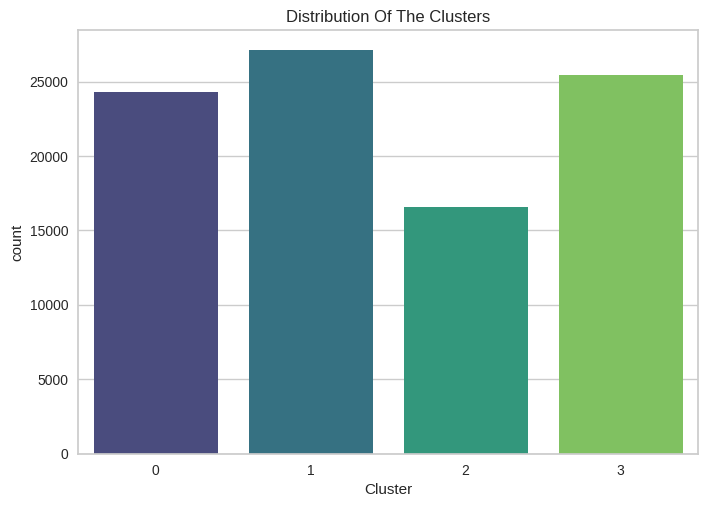

In [11]:
#distribution dans les clusters
pl = sns.countplot(x=data["Cluster"], palette= "viridis")
pl.set_title("Distribution Of The Clusters")
plt.show()

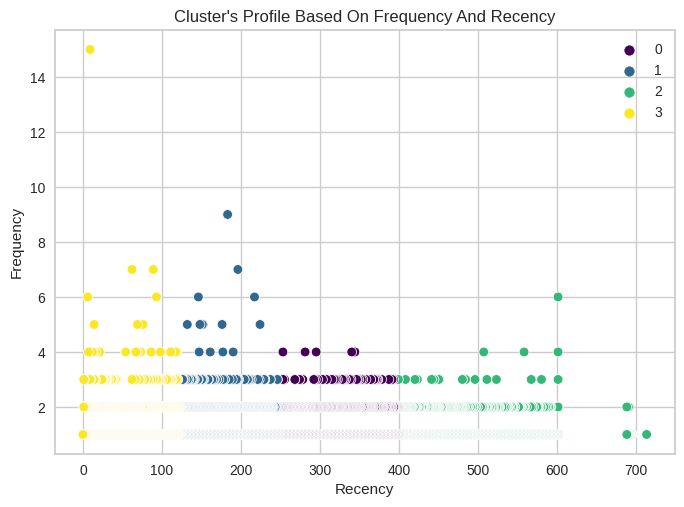

In [13]:
pl = sns.scatterplot(data = data,x=data["Recency"], y=data["Frequency"],hue=data["Cluster"], palette= "viridis")
pl.set_title("Cluster's Profile Based On Frequency And Recency")
plt.legend()
plt.show()

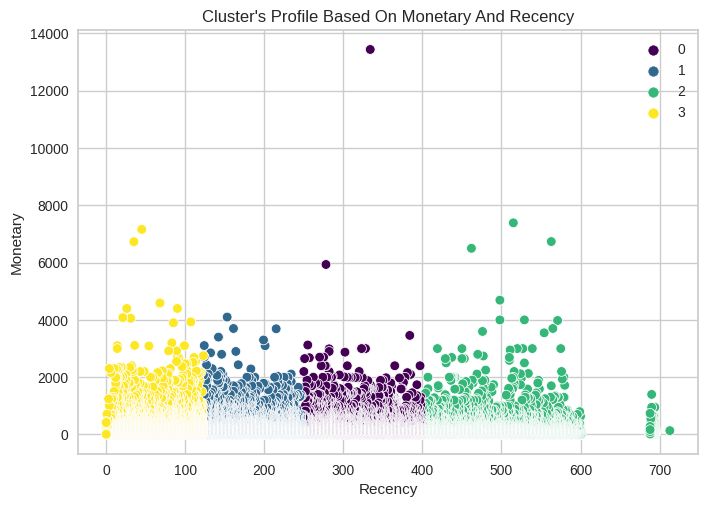

In [14]:
pl = sns.scatterplot(data = data,x=data["Recency"], y=data["Monetary"],hue=data["Cluster"], palette= "viridis")
pl.set_title("Cluster's Profile Based On Monetary And Recency")
plt.legend()
plt.show()

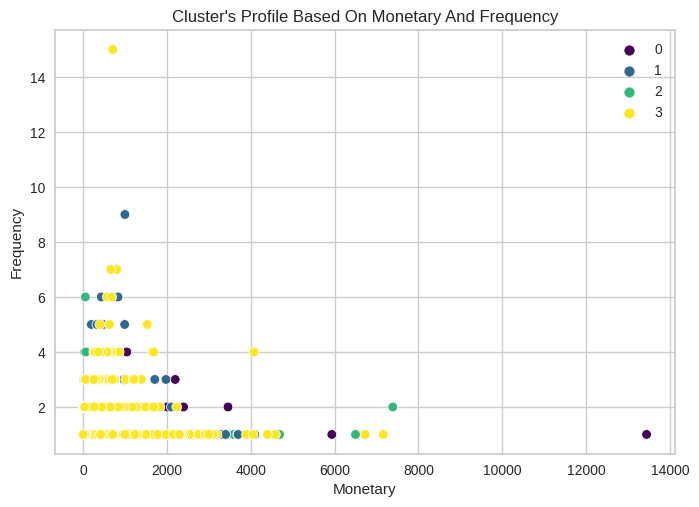

In [15]:
pl = sns.scatterplot(data = data,y=data["Frequency"], x=data["Monetary"],hue=data["Cluster"], palette= "viridis")
pl.set_title("Cluster's Profile Based On Monetary And Frequency")
plt.legend()
plt.show()

In [16]:
data['LastPurchaseDate'].unique()

array(['2016-09-15', '2016-10-03', '2016-10-04', '2016-10-05',
       '2016-10-06', '2016-10-07', '2016-10-08', '2016-10-09',
       '2016-10-10', '2017-01-05', '2017-01-06', '2017-01-07',
       '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11',
       '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19',
       '2017-01-20', '2017-01-21', '2017-01-22', '2017-01-23',
       '2017-01-24', '2017-01-25', '2017-01-26', '2017-01-27',
       '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31',
       '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08',
       '2017-02-09', '2017-02-10', '2017-02-11', '2017-02-12',
       '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16',
       '2017-02-17', '2017-02-18', '2017-02-19', '2017-02-20',
       '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-

In [17]:
data['LastPurchaseDate'].nunique()

611

In [19]:
#reindexation par ordre
data.reset_index(inplace=True)
data

,index,customer_unique_id,LastPurchaseDate,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,Segment,Cluster
0,47882,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15,713,1,134.97,1,3,4,134,At Risk,2
1,35810,61db744d2f835035a5625b59350c6b63,2016-10-03,695,1,36.49,1,2,1,121,Lost customers,2
2,42237,7390ed59fa1febbfda31a80b4318c8cb,2016-10-03,695,1,128.90,1,3,4,134,At Risk,2
3,17361,2f64e403852e6893ae37485d5fcacdaf,2016-10-03,695,1,21.90,1,1,1,111,Lost customers,2
4,49410,87776adb449c551e74c13fc34f036105,2016-10-03,695,1,29.99,1,3,1,131,Lost customers,2
...,...,...,...,...,...,...,...,...,...,...,...,...
93353,90486,f80013faf776e37bcea7634d59c2181e,2018-08-29,0,1,65.00,5,5,2,552,Potential Loyalist,3
93354,33812,5c58de6fb80e93396e2f35642666b693,2018-08-29,0,1,418.00,5,2,5,525,Promising,3
93355,44590,7a22d14aa3c3599238509ddca4b93b01,2018-08-29,0,1,63.90,5,3,2,532,Potential Loyalist,3
93356,46739,7febafa06d9d8f232a900a2937f04338,2018-08-29,0,1,45.90,5,3,2,532,Potential Loyalist,3


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               93358 non-null  int64  
 1   customer_unique_id  93358 non-null  object 
 2   LastPurchaseDate    93358 non-null  object 
 3   Recency             93358 non-null  int64  
 4   Frequency           93358 non-null  int64  
 5   Monetary            93358 non-null  float64
 6   recency_score       93358 non-null  int64  
 7   frequency_score     93358 non-null  int64  
 8   monetary_score      93358 non-null  int64  
 9   RFM_SCORE           93358 non-null  int64  
 10  Segment             93358 non-null  object 
 11  Cluster             93358 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 8.5+ MB


On crée notre dataframe Historique qui regroupe toutes nos données de '2016-09-15' à '2017-08-31'

In [22]:
rfm =  data[data['LastPurchaseDate'] <= '2017-08-31'][['Recency', 'Frequency','Monetary']]

In [23]:
rfm

,Recency,Frequency,Monetary
0,713,1,134.97
1,695,1,36.49
2,695,1,128.90
3,695,1,21.90
4,695,1,29.99
...,...,...,...
21106,363,1,29.90
21107,363,1,325.00
21108,363,1,31.90
21109,363,1,34.60


on met en place notre frequence selon un delta de 14 jours

In [25]:
dT0 = '2017-09-01'
print(type(dT0))
print(dT0)

<class 'str'>
2017-09-01


In [26]:
dT0 = pd.to_datetime(dT0, format='%Y-%m-%d')

In [27]:
dT0


Timestamp('2017-09-01 00:00:00')

In [28]:
liste=[]

for i in range(1,26):
    liste.append(str(dT0 + (timedelta(days=i*14))))
    
print(liste)

['2017-09-15 00:00:00', '2017-09-29 00:00:00', '2017-10-13 00:00:00', '2017-10-27 00:00:00', '2017-11-10 00:00:00', '2017-11-24 00:00:00', '2017-12-08 00:00:00', '2017-12-22 00:00:00', '2018-01-05 00:00:00', '2018-01-19 00:00:00', '2018-02-02 00:00:00', '2018-02-16 00:00:00', '2018-03-02 00:00:00', '2018-03-16 00:00:00', '2018-03-30 00:00:00', '2018-04-13 00:00:00', '2018-04-27 00:00:00', '2018-05-11 00:00:00', '2018-05-25 00:00:00', '2018-06-08 00:00:00', '2018-06-22 00:00:00', '2018-07-06 00:00:00', '2018-07-20 00:00:00', '2018-08-03 00:00:00', '2018-08-17 00:00:00']


In [29]:
ARI_list = list()

## ARI Score

ARI score nous permet d'etudier la ressemblance.
Plus on se rapproche de 1.0 plus nos individus se ressembles, et par consequent plus on sen eloigne plus nos individus perdent en ressemblance

In [31]:
def standard_init_model(df, n):
    """
  
    Cette fonction crée un StandardScaler pour l'ensemble de données initiales, 
    puis effectue un cycle d'ajustement et de transformation.
    En suite on crée un dataframe avec de nouvelles valeurs et on applique cette trame de données 
    pour le modèle KMEANS pour 4 clusters, enfin nous retourne 4 valeurs différentes pour les post-opérations

    
    Paramètres :
    -------------
    df : dataframe
    n : numero d'itteration 
    -------------
    """
    d = {f"std_scale{n}": StandardScaler()}
    d[f"std_scaler{n}"]= d[f"std_scale{n}"].fit(df)
    d[f"scale_RFM{n}"] = d[f"std_scaler{n}"].transform(df)
    d[f"RFM{n}_scaled"]  = pd.DataFrame(d[f"scale_RFM{n}"], columns=df.columns)
    d[f"RFM{n}_model"] = KMeans(n_clusters = 4).fit(d[f"RFM{n}_scaled"])

    return d[f"RFM{n}_scaled"],d[f"std_scale{n}"],d[f"RFM{n}_model"],d[f"scale_RFM{n}"]

In [32]:
C_init = standard_init_model(rfm,0)
C_init[1]

StandardScaler()

In [33]:
def new_model(df, n):
    """
    -La fonction crée un StandardScaler pour l'ensemble de données postérieur, 
    puis effectue un cycle d'ajustement et de transformation.
    
    -Crée une trame de données avec de nouvelles valeurs de jeu de données,
    génère leurs étiquettes et applique cette trame de données pour le modèle KMEANS 
    pour 4 clusters, et crée une nouvelle colonne pour utiliser le StandardScaler initial 
    avant mentionné qui vient d'être ajusté, en appliquant la transformation et 
    la prédiction pour le nouveau jeu de données dans ce créé base de données.
    
    -Calculer le score ARI dépend de ces nouvelles et anciennes colonnes


    Paramètres :
    -------------
    df : dataframe
    n : numéro d'itteration
    -------------
    """
    d = {f"std_scaler{n}": StandardScaler()}
    d[f"std_scaler{n}"]= d[f"std_scaler{n}"].fit(df)
    d[f"scale_RFM{n}"] = d[f"std_scaler{n}"].transform(df)
    d[f"RFM{n}_scaled"]  = pd.DataFrame(d[f"scale_RFM{n}"], columns=DataFrame.columns)
    d[f"RFM{n}_model"] = KMeans(n_clusters = 4).fit(d[f"RFM{n}_scaled"])
    labels = d[f"RFM{n}_model"].labels_

    d[f"RFM{n}_scaled"]['Kmeans_new_Label_ID']=labels
    keys=d[f"RFM{n}_scaled"].groupby('Kmeans_new_Label_ID').Frequency.mean().index
    values=['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
    dictionary = dict(zip(keys, values))

    d[f"RFM{n}_scaled"]['Kmeans1_Label']=d[f"RFM{n}_scaled"].Kmeans_new_Label_ID.apply(lambda x:dictionary[x] )
    scale_RFM_new = C_init[1].transform(df5)
    d[f"RFM{n}_scaled"]['Kmeans_init_pred']=C_init[2].predict(scale_RFM_new)
    keys=d[f"RFM{n}_scaled"].groupby('Kmeans_init_pred').Frequency.mean().index
    values=['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
    dictionary = dict(zip(keys, values))

    d[f"RFM{n}_scaled"]['Kmeans_init_pred_Label']=d[f"RFM{n}_scaled"].Kmeans_init_pred.apply(lambda x:dictionary[x] )
    val_new = adjusted_rand_score(d[f"RFM{n}_scaled"]['Kmeans_new_Label_ID'], d[f"RFM{n}_scaled"]['Kmeans_init_pred'])


    return d[f"RFM{n}_scaled"], val_new

In [34]:
for i in liste:
    rfm = data[data['LastPurchaseDate'] <= i][['Recency', 'Frequency','Monetary']]
   
    model = new_model(rfm,1)
    ARI_list.append(model[1])

In [35]:
ARI_list

[0.7939762248961459,
 0.7156926922750391,
 0.6360339987659935,
 0.5870882406327115,
 0.5643142571166637,
 0.5130519023952295,
 0.44528719461262084,
 0.42641843344731717,
 0.42156613488505446,
 0.38468100212025147,
 0.36686764298665314,
 0.3548243202236358,
 0.3467415660897536,
 0.3463993625225562,
 0.332921740296806,
 0.32832953308769464,
 0.32480005999208245,
 0.3225007666961852,
 0.318069657230163,
 0.31128249524022533,
 0.3087978007188584,
 0.3090291904594682,
 0.30869171312864313,
 0.301125427080847,
 0.21880835465141182]

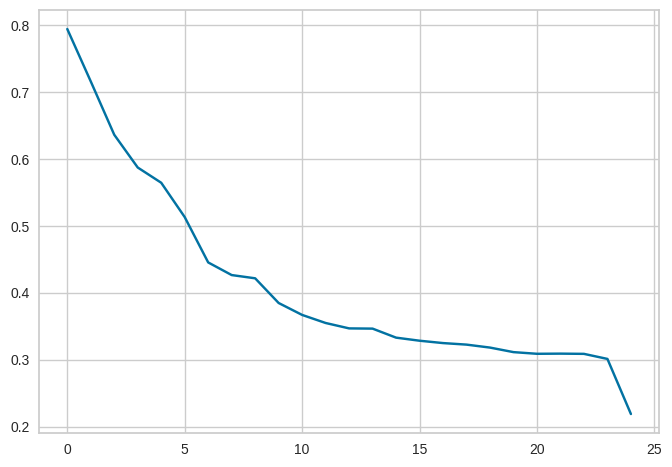

In [36]:
plt.plot(ARI_list)
plt.title = ("RFM Predictions per quarter for clients segmentation with KMeans using ARI by 2 weeks")
plt.show()

Nous remarquons que pendant kes deux deltas nous avons un score de 1.0 (2x 14 jours), et ensuite une chute vers 0.79.
Donc nous proposons une maintenance toutes les quatres semaines.
